In [23]:
import sys
sys.path.append("../gaia_tools/")
sys.path.append("../scripts/")
import data_analysis
import covariance_generation as cov
from import_functions import *
from data_plot import sample_distribution_galactic_coords, plot_radial_distribution, plot_distribution, display_polar_histogram, plot_variance_distribution, plot_velocity_distribution
import numpy as np
import emcee
from functools import reduce
import time, timeit
import transformation_constants
import datetime as dt
import photometric_cut
import os
import pickle
from pathlib import Path
import argparse
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd


Photometric cut..
Stars in the sample before making photometric cuts: (4807089, 22)
Stars in the sample after making photometric cuts: (2528249, 23)
Start import...
The dimensions of the data: (rows, columns) -> (7133471, 24)
Checking indexing... 

<bound method NDFrame.head of                    source_id          ra  ra_error        dec  dec_error  \
0        5933266834310007808  242.471074  0.330682 -52.806533   0.125811   
1        4103049637327213440  278.887615  0.117672 -15.350780   0.103104   
2        5951114420631264640  260.139995  0.042137 -46.794507   0.038528   
3        5966712023814100736  255.893150  0.069434 -41.563702   0.055033   
4        2198292118993038464  331.084711  0.039728  56.898851   0.041073   
...                      ...         ...       ...        ...        ...   
7133466  5959713078252724352  259.808524  0.251540 -41.875976   0.225424   
7133467  4057347680607821696  267.904540  0.079733 -28.918109   0.072635   
7133468  5827538590793373696  234.110

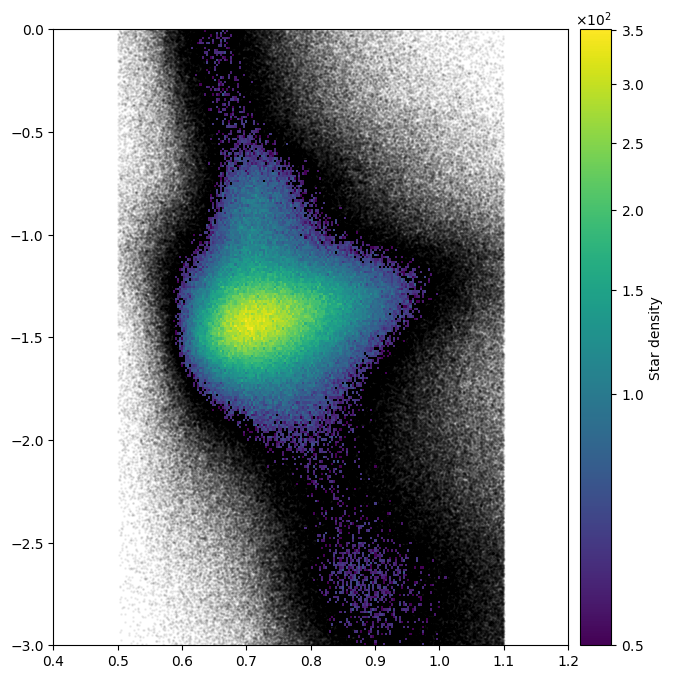

In [3]:
galcen_data, min_r, max_r = import_baseline_sample()

In [16]:
bin_collection.data

,x,y,z,v_x,v_y,v_z,r,phi,v_r,v_phi,source_id,sig_vphi,sig_vr,Bin_index
0,-6713.540228,1433.916865,-107.577977,-262.656928,24.435615,-40.258298,6864.964673,2.931169,261.967334,30.965741,4308426319090935680,8.089332,3.422992,10
1,-7986.845329,1760.840269,182.136689,74.699462,-99.074287,3.325015,8178.646390,2.924596,-94.278076,80.668261,2083679022599920640,1.446958,0.211212,16
2,-8755.960916,242.609513,105.514980,264.616458,-1.163784,-39.671045,8759.321375,3.113892,-264.547173,-6.165822,261639413287206272,0.066719,0.130063,19
3,-7135.508423,2247.835405,83.064339,-368.271627,52.970941,57.035882,7481.192716,2.836413,367.170765,60.129370,2033375785858159616,0.810985,0.098229,13
4,-9088.135721,1872.554198,-17.565173,242.733369,0.083310,47.785964,9279.044677,2.938393,-237.722511,-49.066314,429471440832635776,0.588399,0.452686,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270276,-7717.018051,-786.783808,135.344357,175.750081,-53.965187,18.454374,7757.022390,-3.039989,-169.370094,71.512961,6075808591190731648,0.075257,0.035897,13
270277,-7909.971383,-2428.069263,143.826307,67.766288,-107.323087,186.017248,8274.247254,-2.843760,-33.289011,122.484107,5409010039404246016,0.746723,0.205086,16
270278,-8924.549574,-528.442259,180.532838,-296.440737,13.367163,35.133289,8940.181000,-3.082450,295.132311,-30.866010,3139575566723230848,0.108600,0.157311,19
270279,-8036.201572,-895.052607,-167.809026,135.054053,-203.240904,38.366817,8085.892336,-3.030672,-111.726727,216.941468,5302209488521029632,0.153443,0.036275,16


In [4]:
# Generate bins
bin_collection = data_analysis.get_collapsed_bins(data = galcen_data,
                                                      theta = (0, 1),
                                                      BL_r_min = 5000,
                                                      BL_r_max = 12000,
                                                      BL_z_min = -200,
                                                      BL_z_max = 200,
                                                      N_bins = (10, 1),
                                                      r_drift = False,
                                                      debug = False)

In [20]:
vc_bins = []

for bin in bin_collection.bins:

    rot_vel_var = np.var(bin.data.v_phi, ddof=1)
    rad_vel_var = np.var(bin.data.v_r, ddof=1)

    weights = 1/bin.data.sig_vphi
    weighted_avg, weighted_var = bin.weighted_avg_and_std(bin.data.v_phi, weights)

    R = np.mean(bin.r_boundaries)

    h_r = 3000
    h_sig = 21000

    # v_c_sq = weighted_avg**2 + rot_vel_var - rad_vel_var + R*(1/h_r + 2/h_sig)

    v_c_sq = rad_vel_var*(weighted_avg**2/rad_vel_var + rot_vel_var/rad_vel_var - 1 + R*(1/h_r + 2/h_sig))

    print(R*(1/h_r + 2/h_sig))

    vc_bins.append(np.sqrt(v_c_sq))


2.2928571428571427
2.5928571428571425
2.892857142857143
3.1928571428571426
3.492857142857143
3.7928571428571427
4.0928571428571425
4.392857142857142
4.692857142857142
4.992857142857143


In [24]:
path1 = '/home/svenpoder/repos/gaia-tools/out/mcmc_runs/2022-10-05-11-02-16_range0.3'
paths=[path1]
labels =[]
samplers=[]

# Load run settings
folder_path = path1
with open(folder_path + '/run_settings.txt', 'rb') as handle:
    data = handle.read()
bin_setup = pickle.loads(data)
bin_centers_r = bin_setup['bin_centers_r']
bin_centers_z = bin_setup['bin_centers_z']

for folder_path in paths:
    samplers.append(folder_path+'/sampler_' + folder_path.split('/')[-1].split('_')[0] + '.h5')
    with open(folder_path + '/run_settings.txt', 'rb') as handle:
        bin_setup = pickle.loads(handle.read())
        for i, key in enumerate(bin_setup.keys()):
            print('{}. '.format(i+1) + key + '= {}'.format(bin_setup[key]))
        labels.append(r'$R_0 = {}$ km/s'.format(bin_setup['V_sun'][1][0]))

1. bin_centers_r= [ 5367.81753383  6060.71100158  6753.60446932  7446.49793707
  8139.39140481  8832.28487256  9525.1783403  10218.07180804
 10910.96527579 11603.85874353]
2. bin_centers_z= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3. bin_edges= (array([[ 5021.37079996,  5714.26426771,  6407.15773545,  7100.0512032 ,
         7792.94467094,  8485.83813868,  9178.73160643,  9871.62507417,
        10564.51854192, 11257.41200966, 11950.30547741],
       [ 5021.37079996,  5714.26426771,  6407.15773545,  7100.0512032 ,
         7792.94467094,  8485.83813868,  9178.73160643,  9871.62507417,
        10564.51854192, 11257.41200966, 11950.30547741]]), array([[-200., -200., -200., -200., -200., -200., -200., -200., -200.,
        -200., -200.],
       [ 200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
         200.,  200.]]))
4. nbins= 10
5. V_sun= [[ 11.1]
 [245.8]
 [  7.8]]
6. R_0= 8122
7. Z_0= 25
8. cut_range= 0.3
9. final_sample_size= (270281, 14)
10. disk_scale= 3000.0
11. vlos_dispersio

In [27]:
headers = ['R', 'v_c', 'sig_below', 'sig_above']
eilers_rc = pd.read_csv("/home/svenpoder/repos/gaia-tools/jupyter-notebook/Eilers_RC_Data.csv", sep=' ', names=headers)
eilers_rc.columns

# Rotation Curve Plotting Function

def plot_rotation_curve(is_fit_curve, mcmc_runs, labels, burnin, display_eilers=False, display_bin_edges=False, is_h_fitted = True):

    print("Func")

    def func(x, a, b, c, ):
        return a*x*x + b*x + c

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['black', 'orange', 'blue']
    
    for i_path, path in enumerate(mcmc_runs):

        with open(path + '/run_settings.txt', 'rb') as handle:
            bin_setup = pickle.loads(handle.read())
            bin_centers_r = bin_setup['bin_centers_r']

        path = path + '/sampler_' + path.split('/')[-1].split('_')[0] + '.h5'
        reader = emcee.backends.HDFBackend(path, read_only=True)
        samples_data = reader.get_chain(discard=burnin[i_path])
        flatchain = reader.get_chain(flat=True, discard = burnin[i_path])

        bin_velocities = []
        ndim = samples_data.shape[2]

        if(is_h_fitted):
            ndim = samples_data.shape[2] - 2
        
        for i in range(ndim):
            mcmc = np.percentile(flatchain[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            v_mean, v_sub, v_sup = mcmc[1], q[0], q[1] 
            bin_velocities.append((v_mean, v_sub, v_sup))
        velocity_array = np.array(bin_velocities)

        if(len(mcmc_runs) == 0):
            x_offset = 0
            x_values = bin_centers_r + x_offset
        else:
            x_offset = [-10, 0, 10]
            x_values = bin_centers_r + x_offset[i_path]
        y_values = velocity_array[:,0]

        y_error = [velocity_array[:,1], velocity_array[:,2]]

        print(x_values.shape)
        print(y_values.shape)

        plt.errorbar(x_values, -y_values,
                    yerr= y_error,
                    fmt='o', c=colors[i_path], label=labels[i_path])

        if(is_fit_curve):
            popt, pcov = curve_fit(func, bin_centers_r, -y_values, sigma=velocity_array[:,1])
            perr = np.sqrt(np.diag(pcov))
            fit = func(np.array(bin_centers_r), popt[0], popt[1], popt[2])
            plot(bin_centers_r, fit, colors[i_path], lw=2, linestyle="-", alpha=0.75, label='Fitted curve')

    plt.xlabel(r'$r$ [kpc]', fontdict={'fontsize' : 16})
    plt.ylabel(r'$v_c$ [km/s]',  fontdict={'fontsize' : 16})
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)

    def numfmt(x, pos):
            s = '{}'.format(x / 1000.0)
            return s
    fmt = ticker.FuncFormatter(numfmt)
    ax.xaxis.set_major_formatter(fmt)

    bin_edges_r = bin_setup['bin_edges'][0][0]
    bin_edges_z = bin_setup['bin_edges'][1].T[0]

    if(display_bin_edges):
        y_min = np.min(y_values)
        y_max = np.max(y_values)

        ax.vlines(bin_edges_r, -y_max - 3,-y_min + 1, linestyles='dashed', alpha=0.5, colors='grey')
        ax.set_xticks(np.round(bin_edges_r))

    if(display_eilers):
        reduced_eilers = eilers_rc[eilers_rc.R <= 12]
        eilers_rc_y_values = np.array(reduced_eilers.v_c)
        eilers_rc_x_values = np.array(reduced_eilers.R*1e3)
        eilers_y_error = [np.array(reduced_eilers.sig_below), np.array(reduced_eilers.sig_above)]
        plt.errorbar(eilers_rc_x_values, eilers_rc_y_values, 
                    yerr=eilers_y_error, 
                    fmt='o', 
                    color='red',
                    label='Eilers et al. (2018)')

    plot_computed_vc()

    plt.legend()

In [31]:
def plot_computed_vc():

        bin_centers_r = [np.mean(x.r_boundaries) for x in bin_collection.bins]

        plt.scatter(bin_centers_r, vc_bins, label = 'Computed from Eq. 11')

        plt.xlabel(r'$r$ [kpc]', fontdict={'fontsize' : 16})
        plt.ylabel(r'$v_c$ [km/s]',  fontdict={'fontsize' : 16})
        plt.xticks(fontsize=14, rotation=0)
        plt.yticks(fontsize=14, rotation=0)

        def numfmt(x, pos):
                s = '{}'.format(x / 1000.0)
                return s
        fmt = ticker.FuncFormatter(numfmt)
        ax.xaxis.set_major_formatter(fmt)

Func
(10,)
(10,)


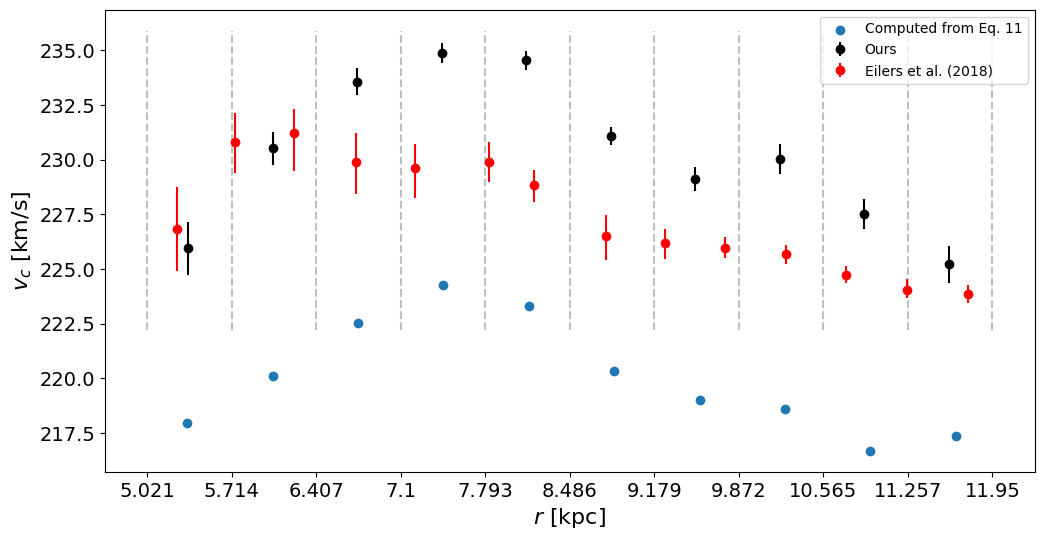

In [32]:
plot_rotation_curve(False, 
                    paths, 
                    ['Ours'], 
                    [2000], display_eilers=True,
                    display_bin_edges=True, is_h_fitted=False)